In [15]:
import torch
import joblib
import pandas as pd
import numpy as np
import gzip
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# set device to gpu
device = (
"cuda"
if torch.cuda.is_available()
else "mps"
if torch.backends.mps.is_available()
else "cpu"
)
device

'mps'

In [16]:
# Load the trained model and scaler

def load_model(model_path):
    model = torch.load(model_path)
    model.to(device)
    model.eval()
    return model

def load_scaler(scaler_path):
    with gzip.open(scaler_path, 'rb') as f:
        scaler = joblib.load(f)
    return scaler

def preprocess_data(new_data, scaler_path):
    scaler = load_scaler(scaler_path)
    # 将列表转换为NumPy数组
    new_data_array = np.array(new_data)
    # 使用加载的标准化器转换数据
    new_data_scaled = scaler.transform(new_data_array)
    return new_data_scaled

# 定义用于分类新数据的函数
def classify_new_data(new_data, model_path, scaler_path):
    model = load_model(model_path)
    preprocessed_data = preprocess_data(new_data, scaler_path)
    preprocessed_data_tensor = torch.tensor(preprocessed_data, dtype=torch.float32).to(device)
    with torch.no_grad():
        predictions = model(preprocessed_data_tensor)
    # 将预测概率转换为0或1
    predictions = (predictions > 0.5).float()
    return predictions.cpu().numpy()

Accuracy: 0.7200


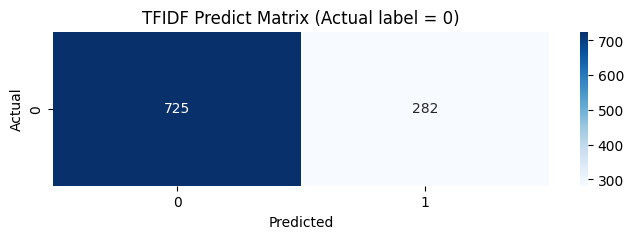

In [17]:
# TFIDF
breeze_tfidf_data_df = pd.read_csv('../Data/breeze_tfidf_vector.csv')
new_data = breeze_tfidf_data_df.iloc[:, 1:-1].values
# 假设所有新数据的真实标签都是0
true_labels = np.zeros(len(new_data))

model_path = '../Data/Model/tfidf_mlp_10fold_model.pth.gz'
scaler_path = '../Data/Model/tfidf_10fold_scaler.pkl.gz'

predictions = classify_new_data(new_data, model_path, scaler_path)

# 準確率
accuracy = accuracy_score(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predictions)

# 只保留实际标签为0的部分
cm_actual_0 = cm[0].reshape(1, -1)

# 绘制部分混淆矩阵
plt.figure(figsize=(8, 2))
sns.heatmap(cm_actual_0, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0'])
plt.title('TFIDF Predict Matrix (Actual label = 0)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.0765


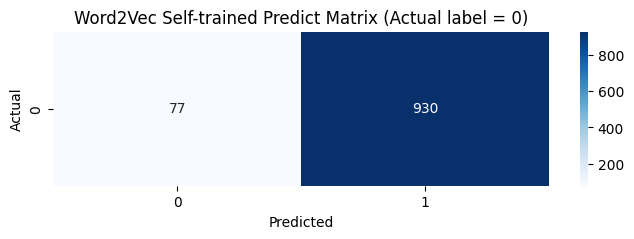

In [18]:
# Word2Vec Self-trained
breeze_word2vec_selftrain_data_df = pd.read_csv('../Data/breeze_word2vec_vector_selftrain.csv')
new_data = breeze_word2vec_selftrain_data_df.iloc[:, 1:-1].values
# 假设所有新数据的真实标签都是0
true_labels = np.zeros(len(new_data))

model_path = '../Data/Model/word2vec_selftrain_mlp_10fold_model.pth.gz'
scaler_path = '../Data/Model/word2vec_selftrain_10fold_scaler.pkl.gz'

predictions = classify_new_data(new_data, model_path, scaler_path)

# 準確率
accuracy = accuracy_score(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predictions)

# 只保留实际标签为0的部分
cm_actual_0 = cm[0].reshape(1, -1)

# 绘制部分混淆矩阵
plt.figure(figsize=(8, 2))
sns.heatmap(cm_actual_0, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0'])
plt.title('Word2Vec Self-trained Predict Matrix (Actual label = 0)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.7527


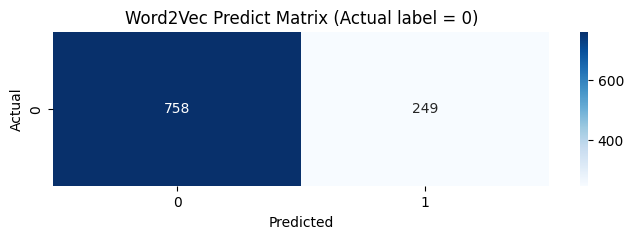

In [19]:
# Word2Vec
breeze_word2vec_data_df = pd.read_csv('../Data/breeze_word2vec_vector.csv')
new_data = breeze_word2vec_data_df.iloc[:, 1:-1].values
# 假设所有新数据的真实标签都是0
true_labels = np.zeros(len(new_data))

model_path = '../Data/Model/word2vec_mlp_10fold_model.pth.gz'
scaler_path = '../Data/Model/word2vec_10fold_scaler.pkl.gz'

predictions = classify_new_data(new_data, model_path, scaler_path)

# 準確率
accuracy = accuracy_score(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predictions)

# 只保留实际标签为0的部分
cm_actual_0 = cm[0].reshape(1, -1)

# 绘制部分混淆矩阵
plt.figure(figsize=(8, 2))
sns.heatmap(cm_actual_0, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0'])
plt.title('Word2Vec Predict Matrix (Actual label = 0)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.7100


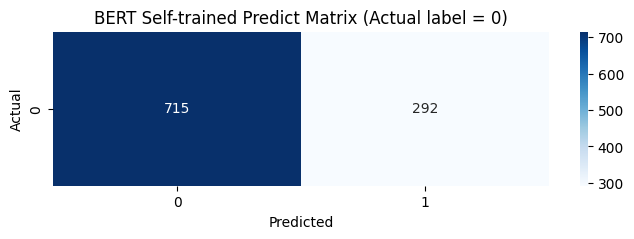

In [20]:
# BERT Self-trained
breeze_bert_selftrain_data_df = pd.read_csv('../Data/breeze_bert_vector_self_train.csv')
new_data = breeze_bert_selftrain_data_df.iloc[:, :-1].values
# 假设所有新数据的真实标签都是0
true_labels = np.zeros(len(new_data))

model_path = '../Data/Model/bert_selftrain_mlp_10fold_model.pth.gz'
scaler_path = '../Data/Model/bert_selftrain_10fold_scaler.pkl.gz'

predictions = classify_new_data(new_data, model_path, scaler_path)

# 準確率
accuracy = accuracy_score(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predictions)

# 只保留实际标签为0的部分
cm_actual_0 = cm[0].reshape(1, -1)

# 绘制部分混淆矩阵
plt.figure(figsize=(8, 2))
sns.heatmap(cm_actual_0, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0'])
plt.title('BERT Self-trained Predict Matrix (Actual label = 0)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.8222


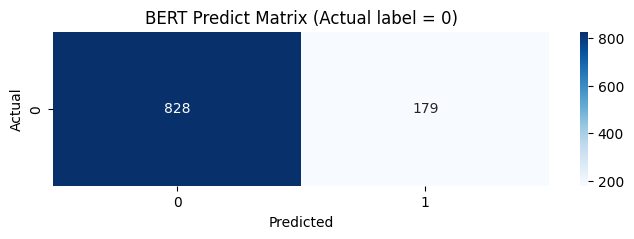

In [21]:
# BERT
breeze_bert_data_df = pd.read_csv('../Data/breeze_bert_vector.csv')
new_data = breeze_bert_data_df.iloc[:, :-1].values
# 假设所有新数据的真实标签都是0
true_labels = np.zeros(len(new_data))

model_path = '../Data/Model/bert_mlp_10fold_model.pth.gz'
scaler_path = '../Data/Model/bert_10fold_scaler.pkl.gz'

predictions = classify_new_data(new_data, model_path, scaler_path)

# 假设所有新数据的真实标签都是0
true_labels = np.zeros(len(new_data))

# 计算精确度、召回率和准确率
accuracy = accuracy_score(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predictions)

# 只保留实际标签为0的部分
cm_actual_0 = cm[0].reshape(1, -1)

# 绘制部分混淆矩阵
plt.figure(figsize=(8, 2))
sns.heatmap(cm_actual_0, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0'])
plt.title('BERT Predict Matrix (Actual label = 0)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()